# Feature Reduction Comparison
In this notebook, I explore different means of feature reduction on greyscale images. In specific, I will compare 
 - Principal Component Analysis, 
 - Flat Auto-Encoder, and 
 - Convolutional Auto-encoder. 
 
The results will be compared both visually and in numbers terms of numbers. The scikit dataset of greyscale faces serves as example.

***This is a work in progress***

In [1]:
import numpy as np
from numpy.linalg import eig, eigvals
from sklearn.datasets import fetch_lfw_people
from src.plot_functions import *

np.random.seed(42)

## Loading and Displaying Dataset 

In [2]:
faces = fetch_lfw_people(min_faces_per_person=50, resize=0.4)

n_samples, h, w = faces.images.shape
n_features = h * w
X = faces.data
np.random.shuffle(X)

print("{} samples in dataset".format(n_samples))
print("{} features per sample".format(n_features))
print("{}x{}px image dimension".format(h, w))

1560 samples in dataset
1850 features per sample
50x37px image dimension


In [3]:
# Shuffling and mean normalization
mu_norm = np.mean(X, axis=1)
X_norm = (X.T - mu_norm).T

In [4]:
# Train and test split
test_ratio = 0.2

n_samples_train = int((1-test_ratio) * X.shape[0])
X_train = X_norm[:n_samples_train]
X_test = X_norm[n_samples_train:]
mu_train = mu_norm[:n_samples_train]
mu_test = mu_norm[n_samples_train:]

print("{} samples in train set".format(X_train.shape[0]))
print("{} samples in test set".format(X_test.shape[0]))

1248 samples in train set
312 samples in test set


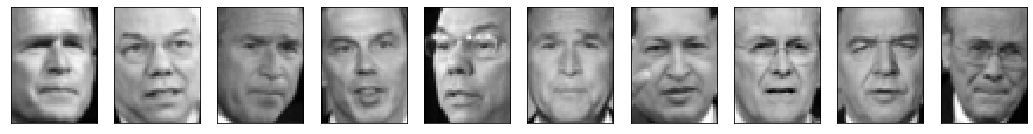

In [5]:
plot_faces(X_train, h, w, 0.8, n_row=1, n_col=10)

## Reduction through PCA

In [6]:
# Compute covariance matrix (equivalent to np.cov(...))
Sigma = 1/n_features * X_train.T.dot(X_train)

# Compute eigenvalues and eigenvectors
eigvals, eigvecs = eig(Sigma)

In [7]:
def get_U_reduce(var_retain, eig):
    """Computes the reduction matrix for PCA"""
    
    eigvals_cumulative = np.array([sum(eig[0:i]) / sum(eig) for i in range(0, len(eig+1))])
    U_n = np.where(eigvals_cumulative >= var_retain)[0][0] + 1
    U_red = eigvecs[:, 0:U_n]
    retention = eigvals_cumulative[U_n-1]
    
    return U_red, retention, eigvals_cumulative

In [8]:
var_retain = 0.99
U_reduce, retention, retention_array = get_U_reduce(var_retain, eigvals)

print("{} features required to retain {:.3f}% of data".format(U_reduce.shape[1], retention*100))

333 features required to retain 99.004% of data


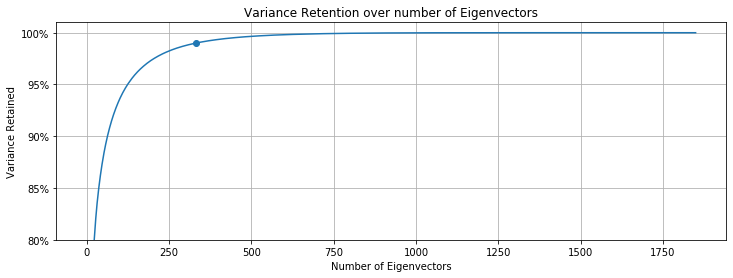

In [9]:
plot_variance_retention(retention_array, var_retain)

In [10]:
def image_similarity(X1, X2):
    """Computes the percentage similarity of two images"""
    
    return 1 - (abs(X1 - X2) / 255.0).mean()

In [11]:
def reduce_and_recover(U_red, X):
    """Reduces features in X according to reduction matrix U_red"""
    
    X_red = X.dot(U_red)
    X_rec = X_red.dot(U_red.T)
    
    return X_rec

In [12]:
# Recover train dataset
X_train_recovered = reduce_and_recover(U_reduce, X_train)

# Reverse the mean normalization
X_train_recovered = (X_train_recovered.T + mu_train).T
X_train_ = (X_train.T + mu_train).T

# Compute the image similarity in %
sim_train = image_similarity(X_train_, X_train_recovered)

print("The train images are {:.3f}% similar".format(sim_train * 100))

The train images are 98.780% similar


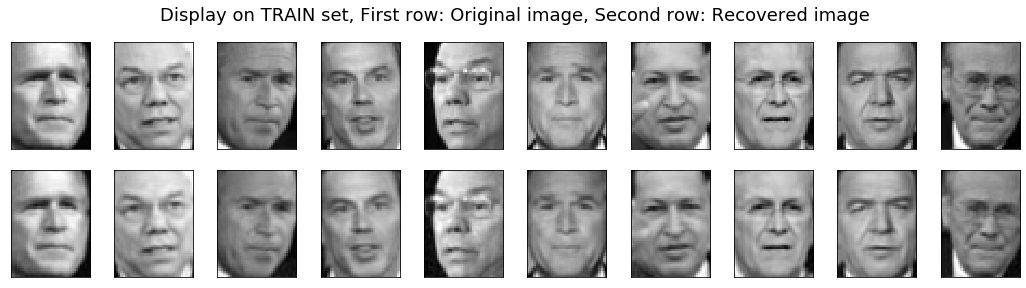

In [13]:
plot_faces_compare(X_train, X_train_recovered, h, w, 0.8, 10, 
                   suptitle="Display on TRAIN set, First row: Original image, Second row: Recovered image")

In [14]:
X_test_recovered = reduce_and_recover(U_reduce, X_test)

# Reverse the mean normalisation
X_test_recovered = (X_test_recovered.T + mu_test).T
X_test_ = (X_test.T + mu_test).T

# Compute the image similarity in %
sim_test = image_similarity(X_test_, X_test_recovered)

print("The test images are {:.3f}% similar".format(sim_test * 100))

The test images are 98.208% similar


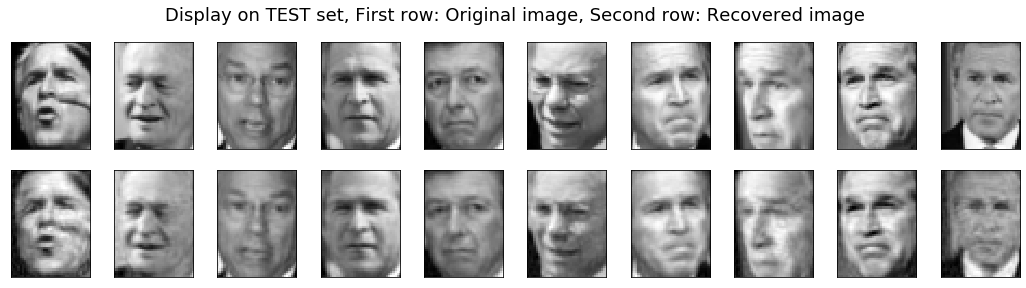

In [15]:
plot_faces_compare(X_test, X_test_recovered, h, w, 0.8, 10,
                  suptitle="Display on TEST set, First row: Original image, Second row: Recovered image")

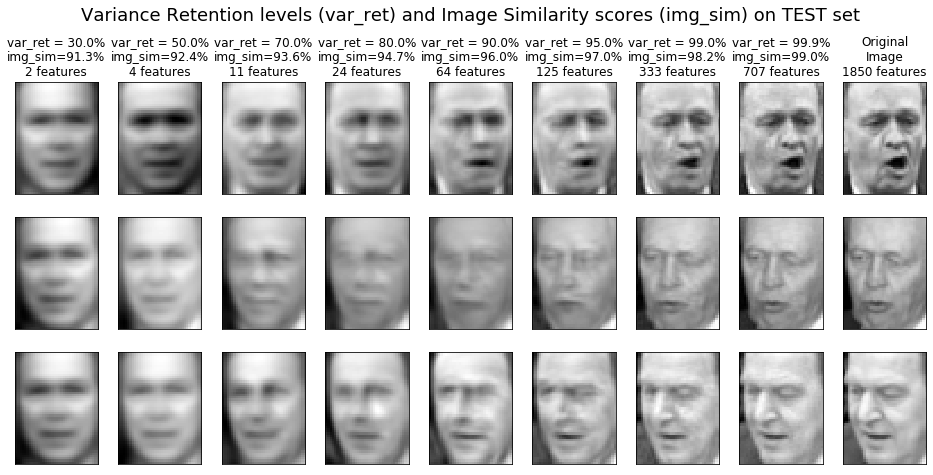

In [16]:
n_images = 3
scaling = 0.9
variance_levels = [0.3, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999]
test_or_train = "TEST" # "TRAIN" or "TEST

X_plot, X_plot_, mu_plot = None, None, None
if test_or_train == "TEST":
    X_plot, X_plot_, mu_plot = X_test, X_test_, mu_test
else:
    X_plot, X_plot_, mu_plot = X_train, X_train_, mu_train

series_images, series_sim, series_features = [], [], []
image_id = np.random.randint(0, X_plot.shape[0], size=(1,n_images))
n_levels = len(variance_levels)

# Perform PCA and recovery for all variance levels
for i_var in variance_levels:
    tmp_U_reduce = get_U_reduce(i_var, eigvals)[0]
    tmp_X_recovered = (reduce_and_recover(tmp_U_reduce, X_plot).T + mu_plot).T
    
    series_features.append(tmp_U_reduce.shape[1])
    series_sim.append(image_similarity(X_plot_, tmp_X_recovered))    
    series_images.append(tmp_X_recovered[image_id])

series_images.append(X_plot[image_id])

# Print example images for different variance levels
plt.figure(figsize=(1.8 * n_levels * scaling, 2.4 * n_images * scaling))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.82, hspace=.20)
plt.suptitle("Variance Retention levels (var_ret) and Image Similarity scores (img_sim) on {} set".format(
        test_or_train), fontsize = 18)

for i in range(n_levels + 1):
    for j in range(n_images):
        plt.subplot(n_images, n_levels + 1, j * (n_levels+1) + i + 1 )
        plt.imshow(series_images[i][0][j].reshape((h, w)), cmap=plt.cm.gray)
        if j == 0:
            if i == n_levels:
                plt.title("Original\nImage\n{} features".format(X_test_.shape[1]))
            else:
                plt.title("var_ret = {:.1f}%\nimg_sim={:.1f}%\n{} features".format(
                        variance_levels[i] * 100, series_sim[i] * 100, series_features[i]))
        plt.xticks(())
        plt.yticks(())

plt.show()

## Reduction through Flat Auto-Encoder

TODO

## Reduction through Convolutional Auto-Encoder

TODO